# Analyzing Covid-19 Vaccination Progress

The Covid-19 epidemic, caused by the coronavirus SARS-CoV-2 emerged in late 2019, and has made profound impact on global health, economies and societies. Covid-19 vaccines were developed and approved for emergency use in record time. The COVAX initiative, led by WHO, Gavi, the Vaccine Alliance, and the Coalition for Epidemic Preparedness Innovations (CEPI), aims to ensure fair and equitable access to vaccines for low- and middle-income countries. 
In this project, we will try to find answers to the following questions:
* What is the overall global progress of the covid-19 vaccination?
* Which countries have the highest and lowest vaccination rates?
* How does the vaccination rate correlate with the countries' population?
* How does the vaccination rate correlate with the country's geographical location?
* What is the prediction for when a country will achieve a certain vaccination threshold (eg: 70% for herd immunity) based on current rates?

First, let me introduce our datasets. We are sourcing majority of our data from a <a href="https://www.kaggle.com/datasets/gpreda/covid-world-vaccination-progress?resource=download" target="_blank">Kaggle database</a>, which collects data daily from the Our World in Data github repository for covid-19. Apart from this, the population data has been obtained from the World Bank's records. 

To begin our analysis, we're going to start with cleaning our data. 


In [297]:
import pandas as pd
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# checking for null values
data = pd.read_csv('country_vaccinations.csv')
data.isna().any().sum()

9

Grouping the data by countries, we can find out the number of unique countries in our dataset. We also convert the date column in the right format to make it easier to work with later. 

In [298]:
country_wise = data.groupby("country")
data["country"].nunique()
data['date'] = pd.to_datetime(data['date'])

After this, we try to find the countries with maximum and minimum vaccination percentages. In our data, we have vaccination percentages by the day for each country. To get to the final vaccination percentage for each country at the end of our timeframe, we find the maximum for each country.

In [299]:
# finding countries with maximum and minimum vaccinated percentages
data.dropna(subset = 'people_fully_vaccinated_per_hundred',inplace = True)
fully_vaxxed = data[['country','date','people_fully_vaccinated_per_hundred']]
indices = fully_vaxxed.groupby('country')['people_fully_vaccinated_per_hundred'].idxmax()
new_indices_max = fully_vaxxed.loc[indices]
max_idx = new_indices_max['people_fully_vaccinated_per_hundred'].idxmax()
max_country = new_indices_max.loc[max_idx]
print(max_country)
new_indices_min = fully_vaxxed.loc[indices]
min_idx = new_indices_min['people_fully_vaccinated_per_hundred'].idxmin()
min_country = new_indices_min.loc[min_idx]
print(min_country)

country                                          Gibraltar
date                                   2022-03-24 00:00:00
people_fully_vaccinated_per_hundred                 122.37
Name: 30235, dtype: object
country                                            Burundi
date                                   2022-03-12 00:00:00
people_fully_vaccinated_per_hundred                   0.08
Name: 12638, dtype: object


We find that Burundi has the least percentage of vaccinated population, at 0.08%. Gibraltar appears to have the highest percentage of vaccinated population, at 122.37%. This is an interesting observation, because it is > 100%. It suggests that our data isn't entirely trustworthy. Potentially, this could be attributed to seperate doses administered for the same people being counted as individual numbers. Another explanation could be counting foreign nationals' statistics, although this is highly unlikely due to the hault in travel during that turbulent time. Further analysis and possibly repeated counting is necessary to draw any further inferences. 

After this, we try to isolate the top 10% and bottom 10% of these countries to observe patterns. 

In [300]:
# getting top 10% and bottom 10% countries
new_indices = pd.DataFrame(new_indices_max)
sorted = new_indices.sort_values(by='people_fully_vaccinated_per_hundred', ascending = False).head(23)
print(sorted)
print(sorted['country'])

                    country       date  people_fully_vaccinated_per_hundred
30235             Gibraltar 2022-03-24                               122.37
62293              Pitcairn 2021-09-07                               100.00
81914  United Arab Emirates 2022-03-27                                96.12
63189              Portugal 2022-03-10                                92.60
11745                Brunei 2022-03-18                                91.71
70228             Singapore 2022-03-28                                91.04
49111                 Malta 2022-03-28                                90.35
15755                 Chile 2022-03-22                                90.29
63647                 Qatar 2022-03-24                                88.50
14701        Cayman Islands 2022-03-25                                87.80
57358                  Niue 2022-03-13                                87.79
19243                  Cuba 2022-03-27                                87.57
72972       

Upon getting the top 10% and bottom 10% of the countries, we try to find common links and patterns. Consulting large language models leads to a couple of interesting observations:
* Of the 23 top 10% countries, 7 are in Europe and 7 are in Asia. The 23 bottom 10% countries on the other hand comprise of 18 countries in Africa
* The average Human Developmental Index for the top 10% of the countries is 0.894. The average HDI for bottom 10% of the countries on the other hand is 0.496, which is significantly lower.
* The total population in the top 10% of the countries is 1.15 billion, over a 1000 times of the population in the lower 10% of the countries, at 1.15 million

In [301]:
print((new_indices).head())

          country       date  people_fully_vaccinated_per_hundred
393   Afghanistan 2022-03-22                                11.10
832       Albania 2022-03-24                                42.30
1237      Algeria 2022-03-09                                13.70
1650      Andorra 2022-03-13                                68.99
2040       Angola 2022-03-25                                17.66


Now that we noticed that a majority of the countries with low vaccination rates are based in Africa, we try to see if it's a similar pattern across the rest of the data. To do this, we will first integrate a continent column to our dataframe. 

In [302]:
# imtegrating continent data
def get_cont(country_name):
    try:
        country_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (LookupError, KeyError):
        return None

In [303]:
# adding continent list as a column
cont_list = []
for country in new_indices['country']:
    continent = get_cont(country)
    cont_list.append(continent)


In [304]:
new_indices['continent'] = cont_list
print(new_indices.head())

          country       date  people_fully_vaccinated_per_hundred continent
393   Afghanistan 2022-03-22                                11.10      Asia
832       Albania 2022-03-24                                42.30    Europe
1237      Algeria 2022-03-09                                13.70    Africa
1650      Andorra 2022-03-13                                68.99    Europe
2040       Angola 2022-03-25                                17.66    Africa


Now that we have the continent column, we get the average vaccination rates for them, and graph it using a bar graph.

In [305]:
# getting mean vaccination rates for all continents
cont_vacc =new_indices.groupby('continent')['people_fully_vaccinated_per_hundred'].mean().reset_index()
print(cont_vacc)

       continent  people_fully_vaccinated_per_hundred
0         Africa                            21.062400
1           Asia                            58.768261
2         Europe                            66.505652
3  North America                            54.918710
4        Oceania                            58.877647
5  South America                            64.871667


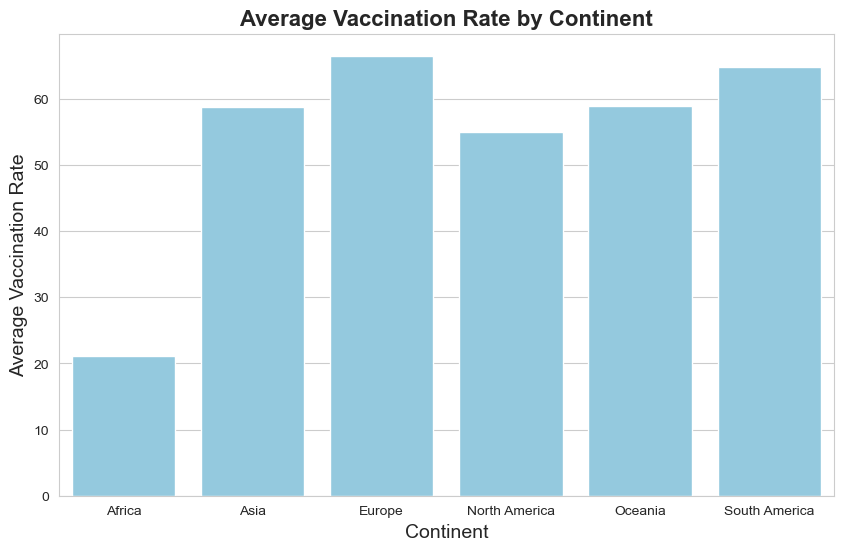

In [306]:
# graph creation
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=cont_vacc,x='continent',y='people_fully_vaccinated_per_hundred',color = 'skyblue')
plt.title('Average Vaccination Rate by Continent', fontsize = 16, fontweight = 'bold')
plt.xlabel('Continent', fontsize = 14)
plt.ylabel('Average Vaccination Rate', fontsize = 14)
plt.show()

Next, we try to work with the population trends. To begin, we integrate a population column in our data.

In [307]:
# integrating population data
pop = pd.read_csv('populations.csv', skiprows = 4)
print(pop.head())
poplist = []
count1 = 0
count2 = 0
for country in new_indices['country']:
    if country in pop['Country Name'].values:
        index = pop[pop['Country Name'] == country].index[0]
        poplist.append(pop.at[index, '2022'])
    else:
        poplist.append(float('nan'))

                  Country Name         2022
0                        Aruba     106445.0
1  Africa Eastern and Southern  720859132.0
2                  Afghanistan   41128771.0
3   Africa Western and Central  490330870.0
4                       Angola   35588987.0


In [308]:
# setting column as poplist, cleaning data again
new_indices['population'] = poplist
cleaned_pop = new_indices[new_indices['population'].notna()]
cleaned_pop['population'].isna().any().sum()

0

We now create a scatterplot to observe trends between population distribution and vaccination rates, by dividing countries into sections of vaccination percentages. 

In [309]:
# scatterplot showing trends between population distribution and vaccination rate
bins = [0, 20, 40, 60, 80, 100]
bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
cleaned_pop = pd.DataFrame(cleaned_pop)
cleaned_pop['Vacc Range'] = pd.cut(cleaned_pop['people_fully_vaccinated_per_hundred'], bins=bins, labels=bin_labels)
cleaned_pop.head()

,country,date,people_fully_vaccinated_per_hundred,continent,population,Vacc Range
393,Afghanistan,2022-03-22,11.10,Asia,41128771.0,0-20%
832,Albania,2022-03-24,42.30,Europe,2777689.0,40-60%
1237,Algeria,2022-03-09,13.70,Africa,44903225.0,0-20%
1650,Andorra,2022-03-13,68.99,Europe,79824.0,60-80%
2040,Angola,2022-03-25,17.66,Africa,35588987.0,0-20%


In [310]:
grouped = cleaned_pop.groupby('Vacc Range')['country'].count().reset_index()
grouped.columns = ['Vacc Range', 'Number of Countries']
print(grouped)

  Vacc Range  Number of Countries
0      0-20%                   39
1     20-40%                   19
2     40-60%                   39
3     60-80%                   63
4    80-100%                   18


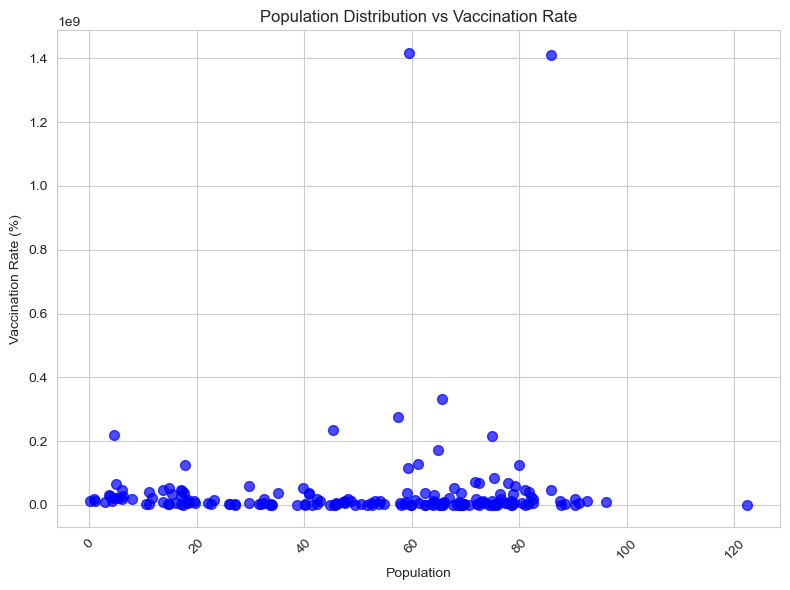

In [311]:
cleaned_pop['Vacc Range'] = cleaned_pop['Vacc Range'].astype(str)
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_pop['people_fully_vaccinated_per_hundred'], cleaned_pop['population'], s=50, c='blue', alpha=0.7)
plt.title('Population Distribution vs Vaccination Rate')
plt.xlabel('Population')
plt.ylabel('Vaccination Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

We now add the population data to our original, unaltered dataframe to work on our prediction model.

In [312]:
# Adding population to data
poplist2 = []
count1 = 0
count2 = 0
for country in data['country']:
    if country in pop['Country Name'].values:
        index = pop[pop['Country Name'] == country].index[0]
        poplist2.append(pop.at[index, '2022'])
    else:
        poplist2.append(float('nan'))
data['population'] = poplist2
print(data.head())

        country iso_code       date  total_vaccinations  people_vaccinated  \
78  Afghanistan      AFG 2021-05-11            504502.0           448878.0   
87  Afghanistan      AFG 2021-05-20            547901.0           470341.0   
91  Afghanistan      AFG 2021-05-24            573277.0           476367.0   
93  Afghanistan      AFG 2021-05-26            590454.0           479372.0   
94  Afghanistan      AFG 2021-05-27            593313.0           479574.0   

    people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
78                  55624.0                     NaN             13921.0   
87                  77560.0                     NaN              4822.0   
91                  96910.0                     NaN              5692.0   
93                 111082.0                     NaN              6768.0   
94                 113739.0                  2859.0              6487.0   

    total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
78         

We also add days since start of our vaccination count for each row of each country, another parameter to be used in our prediction model. 

In [313]:
# Adding column for number of days since start
data.sort_values(['country', 'date'], inplace=True)
data['Start_Date'] = data.groupby('country')['date'].transform('min')
data['Days Since Start'] = (data['date'] - data['Start_Date']).dt.days
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,population,Start_Date,Days Since Start
78,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,NaN,13921.0,1.27,1.13,0.14,349.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,0
87,Afghanistan,AFG,2021-05-20,547901.0,470341.0,77560.0,NaN,4822.0,1.38,1.18,0.19,121.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,9
91,Afghanistan,AFG,2021-05-24,573277.0,476367.0,96910.0,NaN,5692.0,1.44,1.20,0.24,143.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,13
93,Afghanistan,AFG,2021-05-26,590454.0,479372.0,111082.0,NaN,6768.0,1.48,1.20,0.28,170.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,15
94,Afghanistan,AFG,2021-05-27,593313.0,479574.0,113739.0,2859.0,6487.0,1.49,1.20,0.29,163.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,16


Next, we work on the prediction model. We start with forward filling missing data. Then we add a column for the percentage of people fully vaccinated. We create our features list and training, testing datasets. Our target variable here would be the remaining vaccination percentage to reach herd immunity.  

We try to fit our model into a linear regression model, and use it to make predictions on the test data. 

In [322]:
data = data.interpolate(method='ffill')
data['Percentage Fully Vaccinated'] = (data['people_fully_vaccinated_per_hundred'] / data['population']) * 100
monthly_data = data.resample('M', on='date').mean()
features = ['Days Since Start','daily_vaccinations','people_fully_vaccinated','people_vaccinated_per_hundred','people_vaccinated','people_fully_vaccinated_per_hundred', 'population']
data['Target'] = (0.7 * data['population'] - data['people_fully_vaccinated']) / data['daily_vaccinations']
data.dropna(subset=['Target'], inplace=True) 
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Now, let's try to visualize the predictions we just made. We do this by plotting the actual vs expected days to reach herd immunity using our model. The reference line in red (y=x), represents the ideal scenario. 

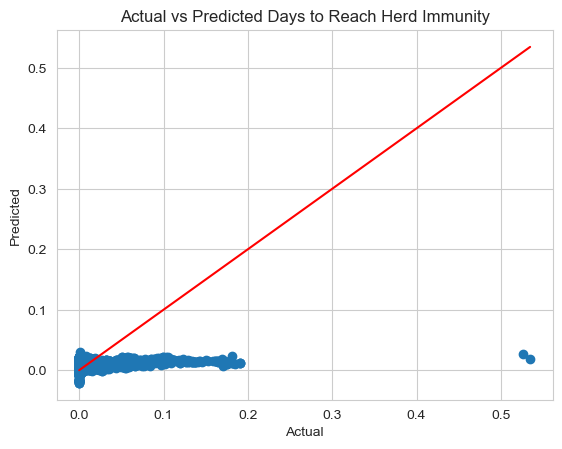

In [323]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Days to Reach Herd Immunity')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

Clearly, our prediction model is flawed. It is very far off from the ideal situation, and so we should try to use some other model. Linear regression is not a good fit, most likely because it is not catching the underlying patterns in our test data. 

So now, we try to find another model that more closely fits our requirements. The Random Forest Aggressor would be a good choice in this case due to non linearity of the data and complex models. We repeat the same process as above for this model. 

Random Forest Model Performance:
Mean Squared Error (MSE): 1.5852101817304976e-06
R-squared (R2): 0.9965374643435038


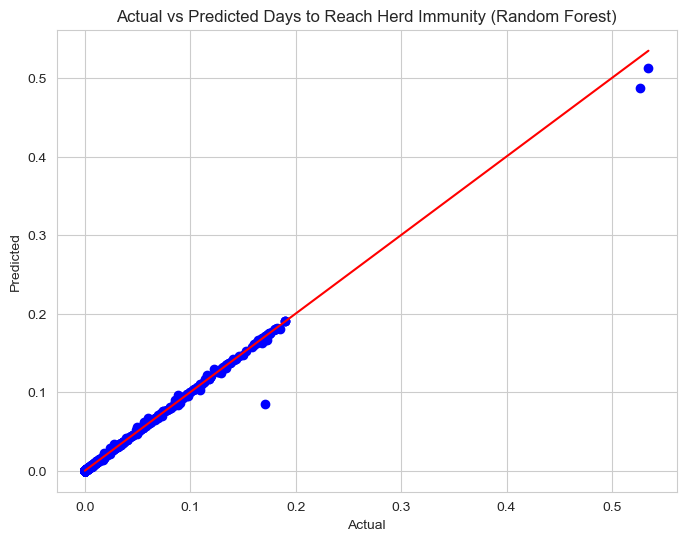

In [318]:
# Random Forest Aggressor
model_rf = RandomForestRegressor(random_state=30)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # y=x line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Days to Reach Herd Immunity (Random Forest)')
plt.grid(True)
plt.show()

We observe that this model is a good fit, as the line of best fit closely matches our predictions. 

Now, we use our model to predict the number of days to reach herd immunity for the countries in our dataset. We also get rid of countries with negative predicted days, because that means we have already reached herd immunity. 

In [325]:
data['Predicted_Days_to_Herd_Immunity'] = model.predict(data[features])
columns_to_check = ['Predicted_Days_to_Herd_Immunity']
data = data[(data[columns_to_check] >= 0).all(axis=1)] 
country_predictions = data[['country', 'Predicted_Days_to_Herd_Immunity']]
ind_count = country_predictions.groupby('country')['Predicted_Days_to_Herd_Immunity'].idxmin()
country_pred = country_predictions.loc[ind_count]
print(country_pred.head(20))

                  country  Predicted_Days_to_Herd_Immunity
139           Afghanistan                         0.000354
823               Albania                         0.000219
1178              Algeria                         0.000989
1336              Andorra                         0.000622
1791               Angola                         0.000559
2118             Anguilla                         0.001771
2546  Antigua and Barbuda                         0.001470
3085            Argentina                         0.000032
3483              Armenia                         0.000161
3670                Aruba                         0.004623
4084            Australia                         0.000002
4546              Austria                         0.000143
5017           Azerbaijan                         0.002451
5376              Bahamas                         0.002743
5777              Bahrain                         0.006152
6277           Bangladesh                         0.0000

In [ ]:
**Summary